Imports & Config

In [84]:
import os, random, re, json, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_recall_fscore_support,
)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
)

import shap
from lime.lime_text import LimeTextExplainer
from scipy.stats import spearmanr

# ---- global config ----
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

DEVICE = torch.device("cpu")
torch.set_num_threads(2)

os.environ["TOKENIZERS_PARALLELISM"] = "false"

TEXT_COL   = "sentences"
LABEL_COL  = "label"
QUALITY_COL= "quality"

BIN_MAP = {"E": 1, "S": 1, "G": 1, "N": 0}
MC_MAP  = {"E": 0, "S": 1, "G": 2, "N": 3}
LABEL_NAMES_BINARY = ["Non-ESG", "ESG"]
LABEL_NAMES_MC     = ["E","S","G","N"]

OUTDIR = "./esg_outputs"
os.makedirs(OUTDIR, exist_ok=True)

Load Dataset

In [85]:
df = pd.read_excel("../data/esgdata_english.xlsx")
display(df.head())
display(df.shape)

,sentences,label,quality
0,We are constantly improving our manufacturing ...,irrelevant text,irrelevant text
1,We actively fulfill our social responsibilities,irrelevant text,irrelevant text
2,"For more information, please visit the company...",irrelevant text,irrelevant text
3,Working together with partners to build a bett...,irrelevant text,irrelevant text
4,Sticking to the original intention and contrib...,irrelevant text,irrelevant text


(8471, 3)

In [86]:
# convert to lowercase safely (handle missing or non-string values)
for col in ["sentences", "label", "quality"]:
    df[col] = df[col].astype(str).str.lower().str.strip()

df.head()

,sentences,label,quality
0,we are constantly improving our manufacturing ...,irrelevant text,irrelevant text
1,we actively fulfill our social responsibilities,irrelevant text,irrelevant text
2,"for more information, please visit the company...",irrelevant text,irrelevant text
3,working together with partners to build a bett...,irrelevant text,irrelevant text
4,sticking to the original intention and contrib...,irrelevant text,irrelevant text


1) Audit labels + quality; detect if E/S/G exists anywhere

In [87]:
print("\nNumber of unique topics:", df[LABEL_COL].nunique())
print("\nUnique topic names:", df[LABEL_COL].unique())
print("\nTopic sample:\n", df[LABEL_COL].value_counts())


Number of unique topics: 37

Unique topic names: ['irrelevant text' 'staff' 'technological innovation' 'raw materials'
 'fighting the epidemic' 'addressing climate change' 'reporting system'
 'organizational structure and operations' 'rural assistance'
 'water resources' 'promoting employment' 'customers and consumers'
 'carbon emissions' 'data security' 'energy and resource consumption'
 'audit work' 'land use' 'anti-corruption and anti-money laundering'
 'information disclosure and investor communication' 'product quality'
 'waste management' 'legal proceedings and external sanctions'
 'intellectual property protection' 'shareholder and creditor rights'
 'public welfare and volunteer service' 'supply chain management'
 'sustainable certification' 'biodiversity' 'environmental policy'
 'green finance' 'anti-unfair competition' 'green building'
 'clean technology' 'chemical safety' 'environmental penalties'
 'tax transparency' 'responsible investment']

Topic sample:
 label
staff     

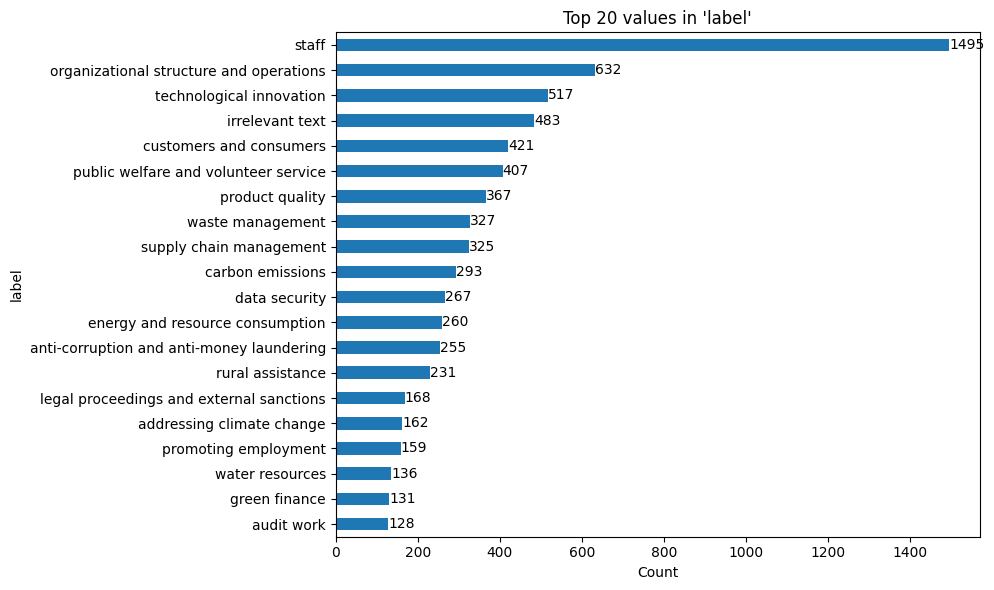

In [88]:
def plot_top_values(df, col, topn=20):
    # normalize to lowercase + strip
    series = df[col].astype(str).str.strip().str.lower()
    series = series[series != ""]
    vc = series.value_counts().head(topn)

    # single chart per requirement
    fig, ax = plt.subplots(figsize=(10, 6))
    vc.iloc[::-1].plot(kind="barh", ax=ax)  # barh for readable labels

    # add count labels
    for i, v in enumerate(vc.iloc[::-1].values):
        ax.text(v, i, str(v), va="center")

    ax.set_title(f"Top {topn} values in '{col}'")
    ax.set_xlabel("Count")
    ax.set_ylabel(col)
    plt.tight_layout()
    plt.show()

# usage
plot_top_values(df, LABEL_COL, topn=20)

2) Cleaning + normalization


In [89]:
TOPIC_TO_MAJOR = {
    "E": [
        "carbon emissions",
        "addressing climate change",
        "water resources",
        "biodiversity",
        "land use",
        "raw materials",
        "energy and resource consumption",
        "waste management",
        "green finance",
        "clean technology",
        "green building",
        "environmental policy",
        "sustainable certification",
        "environmental penalties"
    ],

    "S": [
        "product quality",
        "data security",
        "chemical safety",
        "responsible investment",
        "staff",
        "customers and consumers",
        "promoting employment",
        "supply chain management",
        "public welfare and volunteer service",
        "rural assistance",
        "fighting the epidemic"
    ],

    "G": [
        "technological innovation",
        "organizational structure and operations",
        "information disclosure and investor communication",
        "audit work",
        "reporting system",
        "shareholder and creditor rights",
        "legal proceedings and external sanctions",
        "anti-unfair competition",
        "intellectual property protection",
        "tax transparency",
        "anti-corruption and anti-money laundering"
    ],

    "N": [
        "irrelevant text"
    ]
}

In [90]:
# 1) Build a flat lookup: topic string -> major category
TOPIC_TO_MAJOR_FLAT = {
    topic.lower().strip(): major
    for major, topics in TOPIC_TO_MAJOR.items()
    for topic in topics
}

# 2) Normalize your label column once
label_norm = df[LABEL_COL].astype(str).str.lower().str.strip()

# 3) Map to major category (E/S/G/N). Unseen topics -> "N"
df["major_esg"] = label_norm.map(lambda x: TOPIC_TO_MAJOR_FLAT.get(x, "N"))

# 4) Quick sanity checks
print("Major ESG distribution:")
print(df["major_esg"].value_counts(dropna=False))

# Which labels didn't match your dictionary?
unmapped = label_norm[~label_norm.isin(TOPIC_TO_MAJOR_FLAT.keys())].unique()
if len(unmapped) > 0:
    print("\nUnmapped topic labels (showing up to 30):")
    print(unmapped[:30])

# 5) (Optional) Create a binary target for substantive ESG vs Non-ESG
BIN_MAP = {"E": 1, "S": 1, "G": 1, "N": 0}
df["y_domain_binary"] = df["major_esg"].map(BIN_MAP)

print("\nBinary domain label distribution (ESG=1, Non-ESG=0):")
print(df["y_domain_binary"].value_counts(dropna=False))

# 6) (Optional) Keep the original 4-class id for modeling
MC_MAP = {"E": 0, "S": 1, "G": 2, "N": 3}
df["y_domain_multiclass"] = df["major_esg"].map(MC_MAP)

print("\nMulticlass domain label distribution (E=0,S=1,G=2,N=3):")
print(df["y_domain_multiclass"].value_counts(dropna=False))

Major ESG distribution:
major_esg
S    3859
G    2212
E    1917
N     483
Name: count, dtype: int64

Binary domain label distribution (ESG=1, Non-ESG=0):
y_domain_binary
1    7988
0     483
Name: count, dtype: int64

Multiclass domain label distribution (E=0,S=1,G=2,N=3):
y_domain_multiclass
1    3859
2    2212
0    1917
3     483
Name: count, dtype: int64


In [91]:
# normalize and create the explainability label
df[QUALITY_COL] = df[QUALITY_COL].astype(str).str.lower().str.strip()

def map_quality(q):
    if "quantitative" in q:
        return 1   # substantive
    if "qualitative" in q:
        return 0   # vague
    return None    # irrelevant / drop

df["y_explainability"] = df[QUALITY_COL].apply(map_quality)
print("Explainability label counts:\n", df["y_explainability"].value_counts(dropna=False))

# keep only quantitative / qualitative rows
d_expl = df.dropna(subset=["y_explainability"]).copy()
print("After filtering:", d_expl.shape)

Explainability label counts:
 y_explainability
0.0    5889
1.0    2099
NaN     483
Name: count, dtype: int64
After filtering: (7988, 7)


In [92]:
display(d_expl.head())

,sentences,label,quality,major_esg,y_domain_binary,y_domain_multiclass,y_explainability
5,the company supports the growth of female empl...,staff,qualitative text,S,1,1,0.0
8,won the ces2023 innovation award,technological innovation,qualitative text,G,1,2,0.0
12,"in terms of cost, we can purchase raw material...",raw materials,qualitative text,E,1,0,0.0
14,serving patients around the world for many years,fighting the epidemic,qualitative text,S,1,1,0.0
15,managing climate risks in business activities,addressing climate change,qualitative text,E,1,0,0.0


In [93]:
d_expl["y_explainability"].value_counts()

y_explainability
0.0    5889
1.0    2099
Name: count, dtype: int64

In [94]:
train_df, temp_df = train_test_split(
    d_expl[["sentences", "y_explainability"]],
    test_size=0.2, random_state=42, stratify=d_expl["y_explainability"]
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, random_state=42, stratify=temp_df["y_explainability"]
)

print({k: v.shape for k,v in [("train",train_df),("val",val_df),("test",test_df)]})

{'train': (6390, 2), 'val': (799, 2), 'test': (799, 2)}


Baseline — TF-IDF + Logistic Regression

Baseline results (VAL):
              precision    recall  f1-score   support

       vague       0.88      0.98      0.93       589
 substantive       0.91      0.61      0.74       210

    accuracy                           0.88       799
   macro avg       0.90      0.80      0.83       799
weighted avg       0.89      0.88      0.88       799



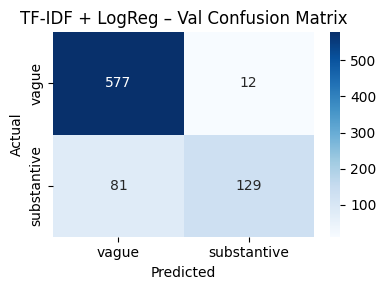

In [95]:
np.random.seed(42)

# ---- Baseline: TF–IDF + Logistic Regression ----
train_texts = train_df[TEXT_COL].astype(str).str.strip().tolist()
val_texts   = val_df[TEXT_COL].astype(str).str.strip().tolist()
y_train     = train_df["y_explainability"].astype(int).values
y_val       = val_df["y_explainability"].astype(int).values

tfidf = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1, 2),
    lowercase=True,
)

Xtr = tfidf.fit_transform(train_texts)
Xva = tfidf.transform(val_texts)

clf = LogisticRegression(max_iter=1000, n_jobs=-1)
clf.fit(Xtr, y_train)

pred_val = clf.predict(Xva)
print("Baseline results (VAL):")
print(classification_report(y_val, pred_val, target_names=["vague","substantive"]))

cm_base = confusion_matrix(y_val, pred_val)
plt.figure(figsize=(4,3))
sns.heatmap(cm_base, annot=True, fmt="d", cmap="Blues",
            xticklabels=["vague","substantive"],
            yticklabels=["vague","substantive"])
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.title("TF-IDF + LogReg – Val Confusion Matrix")
plt.tight_layout()
plt.show()

In [96]:
# Build SHAP explainer (LinearExplainer)

# LinearExplainer works directly on the numeric feature space of a linear model
# Background data: small subset of training features
bg_size = min(200, Xtr.shape[0])
bg_idx  = np.random.choice(Xtr.shape[0], size=bg_size, replace=False)
background_X = Xtr[bg_idx]

# Create SHAP LinearExplainer for the logistic regression model
explainer = shap.LinearExplainer(
    clf,              # trained LogisticRegression
    background_X,     # background data in TF-IDF space
)


In [97]:
# Choose a small eval subset from validation and get SHAP values

# Make a small balanced subset from validation
df_base = val_df.copy()
N_TOTAL = 30
per_class = N_TOTAL // 2
parts = []
for lab in [0, 1]:    # 0=vague, 1=substantive
    df_lab = df_base[df_base["y_explainability"] == lab]
    n = min(per_class, len(df_lab))
    parts.append(df_lab.sample(n, random_state=42))

subset_base = pd.concat(parts).sample(frac=1, random_state=42).reset_index(drop=True)
texts_base  = subset_base["sentences"].astype(str).str.strip().tolist()
labels_base = subset_base["y_explainability"].astype(int).tolist()

# TF-IDF features for this subset
X_eval = tfidf.transform(texts_base)

# Compute SHAP values
# For binary classification, LinearExplainer gives array of shape (N, num_features)
shap_values = explainer.shap_values(X_eval)   # shape: (N_TOTAL, num_features)
print("\nSHAP values shape:", shap_values.shape)

feature_names = np.array(tfidf.get_feature_names_out())



SHAP values shape: (30, 20000)


In [98]:
# Helper: inspect top SHAP features per example

def get_top_shap_features_for_example(i, k=10):
    """
    i: index in 0..N_TOTAL-1
    returns: list of (feature, shap_value)
    """
    shap_vec = shap_values[i]  # (num_features,)
    order = np.argsort(-np.abs(shap_vec))[:k]
    feats  = feature_names[order]
    scores = shap_vec[order]
    return list(zip(feats, scores))

K = 10  # number of features per example

rows = []
for i in range(len(texts_base)):
    top_feats = get_top_shap_features_for_example(i, k=K)
    for feat, sc in top_feats:
        rows.append({
            "text": texts_base[i],
            "true_label": labels_base[i],
            "feature": feat,
            "shap_value": float(sc),
        })

df_shap_top = pd.DataFrame(rows)
display(df_shap_top)

,text,true_label,feature,shap_value
0,962022social responsibility report category co...,1,total,0.327800
1,962022social responsibility report category co...,1,2022,0.321622
2,962022social responsibility report category co...,1,in 2022,0.236488
3,962022social responsibility report category co...,1,years,0.222293
4,962022social responsibility report category co...,1,years old,0.130803
...,...,...,...,...
295,the internal control management center is an i...,0,internal,-0.077077
296,the internal control management center is an i...,0,control,-0.073527
297,the internal control management center is an i...,0,2022,-0.071900
298,the internal control management center is an i...,0,important,-0.068168


/var/folders/2y/n4w9x7353854bqjz2kyz8y300000gn/T/ipykernel_20393/3079772539.py:5: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


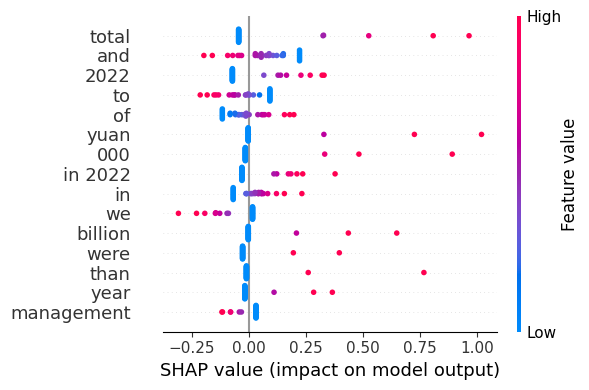

In [99]:
# Convert sparse matrix to dense for plotting
X_eval_dense = X_eval.toarray()

plt.figure(figsize=(6, 4))   
shap.summary_plot(
    shap_values,
    X_eval_dense,
    feature_names=feature_names,
    max_display=15,         
    show=True,
    plot_size=(6,4)         
)

**Y-axis = Words (Features):**
Each row is a single word or bigram (e.g., total, billion, more than, training, etc.).
These are the most important words across all 30 examples explained.

**Each Dot = One Example:**
Every dot is one of your 30 sentences in the SHAP batch.
So if a row has many dots, that word appears in many examples

**X-axis = SHAP Value (Impact on Prediction):**
- Positive SHAP value → pushes toward “substantive” (quantitative).
- Negative SHAP value → pushes toward “vague.”
- Magnitude = how strong the contribution is.

Fine-tune DistilBERT (substantive vs vague)

In [100]:
# ---------------- CONFIG ----------------
MODEL_NAME   = "distilbert-base-uncased"
MAX_LEN      = 128                # shorter sentences → faster
EPOCHS       = 1                  # single epoch = quick prototype
LR           = 2e-5
BATCH_TRAIN  = 8                  # smaller batch for CPU
BATCH_EVAL   = 16
MAX_STEPS    = 500                # limit total training steps
SAMPLE_TRAIN = 3000
SAMPLE_VAL   = 600
SAMPLE_TEST  = 600
DEVICE       = torch.device("cpu")
torch.set_num_threads(2)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
# ----------------------------------------

# subsample dataset for quick run
train_small = train_df.sample(min(SAMPLE_TRAIN, len(train_df)), random_state=SEED)
val_small   = val_df.sample(min(SAMPLE_VAL, len(val_df)), random_state=SEED)
test_small  = test_df.sample(min(SAMPLE_TEST, len(test_df)), random_state=SEED)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# ensure integer labels
for df_ in (train_small, val_small, test_small):
    df_["labels"] = df_["y_explainability"].astype("int64")

def tok(batch):
    return tokenizer(
        batch["sentences"],
        truncation=True,
        padding="max_length",
        max_length=MAX_LEN
    )

def to_hfds(df_):
    ds = Dataset.from_pandas(df_[["sentences", "labels"]].reset_index(drop=True))
    ds = ds.map(tok, batched=True, remove_columns=["sentences"])
    ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
    return ds

hf_train = to_hfds(train_small)
hf_val   = to_hfds(val_small)
hf_test  = to_hfds(test_small)

def metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    y = p.label_ids
    acc = accuracy_score(y, preds)
    pr, rc, f1, _ = precision_recall_fscore_support(
        y, preds, average="macro", zero_division=0
    )
    return {
        "accuracy":        acc,
        "f1_macro":        f1,
        "precision_macro": pr,
        "recall_macro":    rc,
    }

# note: attn_implementation="eager" avoids the SDPA warning
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
    attn_implementation="eager",   # <- important for attention later
)
model.config.problem_type = "single_label_classification"
model.config.id2label = {0: "vague", 1: "substantive"}
model.config.label2id = {"vague": 0, "substantive": 1}
model.to(DEVICE)

args = TrainingArguments(
    output_dir="./esg_explainability_cpu",
    learning_rate=LR,
    per_device_train_batch_size=BATCH_TRAIN,
    per_device_eval_batch_size=BATCH_EVAL,
    num_train_epochs=EPOCHS,
    max_steps=MAX_STEPS,        # will stop early if hits max steps
    weight_decay=0.01,
    logging_steps=50,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=hf_train,
    eval_dataset=hf_val,
    tokenizer=tokenizer,
    compute_metrics=metrics,
)

start = time.time()
trainer.train()
print(f"\n⏱ Training completed in {(time.time()-start)/60:.2f} min")

val_metrics = trainer.evaluate()
test_metrics = trainer.evaluate(hf_test)
print("\nVAL:", val_metrics)
print("\nTEST:", test_metrics)

Map: 100%|██████████| 600/600 [00:00<00:00, 6492.24 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/2y/n4w9x7353854bqjz2kyz8y300000gn/T/ipykernel_20393/2862931263.py:87: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Users/rashisolanki/Documents/USC/3rd_sem/CSCI 544 - Applied NLP/project/code/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
50,0.532900
100,0.246600
150,0.251600
200,0.190300
250,0.224100
300,0.222600
350,0.231400
400,0.160900
450,0.175500
500,0.109700



⏱ Training completed in 2.89 min


/Users/rashisolanki/Documents/USC/3rd_sem/CSCI 544 - Applied NLP/project/code/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


/Users/rashisolanki/Documents/USC/3rd_sem/CSCI 544 - Applied NLP/project/code/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)



VAL: {'eval_loss': 0.21775569021701813, 'eval_accuracy': 0.9316666666666666, 'eval_f1_macro': 0.9090905731358948, 'eval_precision_macro': 0.8997747747747749, 'eval_recall_macro': 0.9197044334975369, 'eval_runtime': 7.0984, 'eval_samples_per_second': 84.527, 'eval_steps_per_second': 5.353, 'epoch': 1.3333333333333333}

TEST: {'eval_loss': 0.22537221014499664, 'eval_accuracy': 0.9366666666666666, 'eval_f1_macro': 0.9180457506002789, 'eval_precision_macro': 0.9146878877337099, 'eval_recall_macro': 0.9215657847046032, 'eval_runtime': 6.6715, 'eval_samples_per_second': 89.935, 'eval_steps_per_second': 5.696, 'epoch': 1.3333333333333333}


In [101]:
save_path = "./esg_explainability_cpu_final"
trainer.save_model(save_path)
tokenizer.save_pretrained(save_path)
print("Model saved to:", save_path)

Model saved to: ./esg_explainability_cpu_final


/Users/rashisolanki/Documents/USC/3rd_sem/CSCI 544 - Applied NLP/project/code/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/rashisolanki/Documents/USC/3rd_sem/CSCI 544 - Applied NLP/project/code/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[[424  21]
 [ 17 138]]


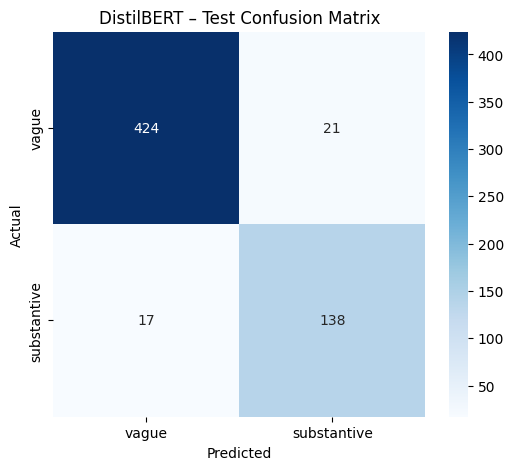

In [102]:
# Get predictions and true labels
preds = np.argmax(trainer.predict(hf_test).predictions, axis=1)
labels = trainer.predict(hf_test).label_ids

# Compute confusion matrix
cm = confusion_matrix(labels, preds)
print(cm)

# Plot colored confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["vague","substantive"], yticklabels=["vague","substantive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("DistilBERT – Test Confusion Matrix")
plt.show()

LIME

In [103]:
from lime.lime_text import LimeTextExplainer
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F

# Make sure model is in eval mode and on CPU
DEVICE = torch.device("cpu")
model.to(DEVICE)
model.eval()

MAX_LEN = 128  # same as training


# ==========================
# 1. DistilBERT predict_proba wrapper
# ==========================
def predict_proba_distilbert(texts):
    """
    texts: list-like of raw strings
    returns: np.ndarray of shape (N, 2) with [p(vague), p(substantive)]
    """
    if isinstance(texts, pd.Series):
        texts = texts.tolist()
    else:
        texts = list(texts)

    enc = tokenizer(
        texts,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=MAX_LEN,
    )
    enc = {k: v.to(DEVICE) for k, v in enc.items()}
    with torch.no_grad():
        logits = model(**enc).logits
        probs = F.softmax(logits, dim=-1).cpu().numpy()
    return probs


# Quick sanity check
print("Probabilities test:", predict_proba_distilbert(test_df["sentences"].head(2)))



Probabilities test: [[0.0184453 0.9815547]
 [0.9956268 0.0043732]]


In [104]:
# ==========================
# 2. Build eval subset (correctly predicted, balanced)
# ==========================
test_texts  = test_df["sentences"].astype(str).str.strip().tolist()
test_labels = test_df["y_explainability"].astype(int).to_numpy()

test_probs  = predict_proba_distilbert(test_texts)
test_preds  = test_probs.argmax(axis=1)

mask_correct = (test_preds == test_labels)
correct_idx  = np.where(mask_correct)[0]

N_EVAL   = 40        # total examples to explain
per_class = N_EVAL // 2

idx_subset = []
for c in [0, 1]:  # 0=vague, 1=substantive
    idx_c = correct_idx[test_labels[correct_idx] == c]
    n = min(per_class, len(idx_c))
    if n > 0:
        idx_subset.extend(np.random.choice(idx_c, size=n, replace=False))

idx_subset = np.array(idx_subset)
np.random.shuffle(idx_subset)

texts_eval  = [test_texts[i] for i in idx_subset]
labels_eval = [int(test_labels[i]) for i in idx_subset]
preds_eval  = [int(test_preds[i])  for i in idx_subset]

print("LIME eval subset size:", len(texts_eval))
print("Label counts in subset:", pd.Series(labels_eval).value_counts())


LIME eval subset size: 40
Label counts in subset: 1    20
0    20
Name: count, dtype: int64


In [105]:
# ==========================
# 3. Initialize LIME explainer
# ==========================
class_names = ["vague", "substantive"]
explainer_lime = LimeTextExplainer(class_names=class_names)


# ==========================
# 4. Run LIME for each example and store in DataFrame
# ==========================
lime_rows = []

for i, txt in enumerate(texts_eval):
    true_c = labels_eval[i]
    pred_c = preds_eval[i]

    # LIME explanation around this instance
    exp = explainer_lime.explain_instance(
        txt,
        predict_proba_distilbert,  # prediction function on raw text
        num_features=10,           # top k features (tokens/phrases)
        labels=[0, 1],             # explain both classes, we’ll pick predicted
        num_samples=500,           # perturbation samples (tradeoff speed/quality)
    )

    # Get explanation for the predicted class
    feats = exp.as_list(label=pred_c)  # list of (feature, weight)

    for feature, weight in feats:
        lime_rows.append({
            "idx": i,                 # index inside texts_eval
            "text": txt,
            "true_label": true_c,
            "pred_label": pred_c,
            "method": "LIME",
            "feature": feature,       # token or phrase
            "score": float(weight),   # positive → pushes toward pred_label
        })

df_lime = pd.DataFrame(lime_rows)
print("LIME explanations shape:", df_lime.shape)
display(df_lime.head())

LIME explanations shape: (400, 7)


,idx,text,true_label,pred_label,method,feature,score
0,0,its environmental management institutions and ...,1,1,LIME,no,0.747481
1,0,its environmental management institutions and ...,1,1,LIME,occurred,0.114000
2,0,its environmental management institutions and ...,1,1,LIME,environmental,0.113319
3,0,its environmental management institutions and ...,1,1,LIME,violations,0.086242
4,0,its environmental management institutions and ...,1,1,LIME,have,0.079442


In [106]:
display(df_lime)

,idx,text,true_label,pred_label,method,feature,score
0,0,its environmental management institutions and ...,1,1,LIME,no,0.747481
1,0,its environmental management institutions and ...,1,1,LIME,occurred,0.114000
2,0,its environmental management institutions and ...,1,1,LIME,environmental,0.113319
3,0,its environmental management institutions and ...,1,1,LIME,violations,0.086242
4,0,its environmental management institutions and ...,1,1,LIME,have,0.079442
...,...,...,...,...,...,...,...
395,39,continue to improve data security and privacy ...,0,0,LIME,improve,0.000162
396,39,continue to improve data security and privacy ...,0,0,LIME,and,0.000162
397,39,continue to improve data security and privacy ...,0,0,LIME,data,0.000157
398,39,continue to improve data security and privacy ...,0,0,LIME,to,0.000149


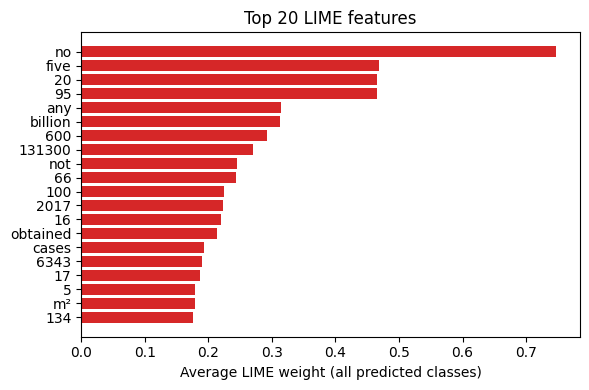

In [107]:
import matplotlib.pyplot as plt
import numpy as np

# -------------------------
# 1. (Optional) focus on one class
# -------------------------
PRED_CLASS = 1   # 1 = substantive, 0 = vague

df_lime_sub = df_lime.copy()

# -------------------------
# 2. Aggregate feature scores
#    mean score ≈ average contribution
#    abs_mean   ≈ overall importance
# -------------------------
agg = (
    df_lime_sub
    .groupby("feature")["score"]
    .agg(["mean", "count"])
)

agg["abs_mean"] = agg["mean"].abs()

TOP_K = 20
top = agg.sort_values("abs_mean", ascending=False).head(TOP_K)

# -------------------------
# 3. Plot horizontal bar chart
# -------------------------
features = top.index.tolist()
means    = top["mean"].values

colors = ["tab:red" if m > 0 else "tab:blue" for m in means]

plt.figure(figsize=(6,4))
y_pos = np.arange(len(features))

plt.barh(y_pos, means, color=colors)
plt.yticks(y_pos, features)
plt.gca().invert_yaxis()  # most important at top

plt.xlabel("Average LIME weight (all predicted classes)")
plt.title(f"Top {TOP_K} LIME features")
plt.tight_layout()
plt.show()

Attention

In [108]:
import torch
import numpy as np
import pandas as pd

model.eval()
DEVICE = torch.device("cpu")   # you’re on CPU
model.to(DEVICE)

def get_attention_importance(texts, max_len=128):
    """
    Returns:
      input_ids: (B, L-1) token ids (without [CLS])
      attn_scores: (B, L-1) attention scores from [CLS] → tokens
    """
    enc = tokenizer(
        texts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=max_len
    ).to(DEVICE)

    with torch.no_grad():
        out = model(**enc, output_attentions=True)

    # out.attentions: (num_layers, B, num_heads, L, L)
    last = out.attentions[-1].mean(dim=2)   # avg over heads → (B, L, L)

    # attention FROM CLS (position 0) TO every token
    cls_to_tok = last[:, 0, :]             # (B, L)

    # drop CLS itself, keep everything else
    attn_scores = cls_to_tok[:, 1:]        # (B, L-1)
    input_ids   = enc["input_ids"][:, 1:]  # (B, L-1)

    return input_ids.cpu(), attn_scores.cpu()

# run on the same examples you used for LIME
input_ids_attn, attn_scores = get_attention_importance(texts_eval)

print(input_ids_attn.shape, attn_scores.shape)

torch.Size([40, 127]) torch.Size([40, 127])


Attention

In [109]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

DEVICE = torch.device("cpu")

model = AutoModelForSequenceClassification.from_pretrained("./esg_explainability_cpu_final")
tokenizer = AutoTokenizer.from_pretrained("./esg_explainability_cpu_final")

model.to(DEVICE)
model.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [110]:
# Use the same balanced subset you used earlier (labels_eval, texts_eval)
texts_attn = texts_eval
labels_attn = labels_eval

len(texts_attn)

40

In [111]:
import numpy as np

def get_cls_attention(text):
    """Returns: tokens, attention_scores (1D numpy array)"""

    encoding = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=128
    ).to(DEVICE)

    with torch.no_grad():
        outputs = model(**encoding, output_attentions=True)

    # outputs.attentions: list of 6 layers
    attn_layers = outputs.attentions  # len=6

    # Last layer attention: (1, num_heads, seq_len, seq_len)
    last = attn_layers[-1][0].cpu().numpy()

    # CLS = index 0
    cls_to_all = last[:, 0, :]        # (num_heads, seq_len)

    # average across heads
    mean_attn = cls_to_all.mean(axis=0)  # (seq_len,)

    # convert token ids → strings
    ids = encoding["input_ids"][0].cpu().numpy()
    tokens = tokenizer.convert_ids_to_tokens(ids)

    return tokens, mean_attn

In [112]:
attn_rows = []

for i, txt in enumerate(texts_attn):
    tokens, scores = get_cls_attention(txt)

    # truncate at PAD tokens
    cleaned = [(t, float(s)) for t, s in zip(tokens, scores) if t != "[PAD]"]

    for tok, val in cleaned:
        attn_rows.append({
            "idx": i,
            "text": txt,
            "true_label": int(labels_attn[i]),
            "token": tok,
            "score": val
        })

df_attn = pd.DataFrame(attn_rows)
df_attn.head()

,idx,text,true_label,token,score
0,0,its environmental management institutions and ...,1,[CLS],0.070233
1,0,its environmental management institutions and ...,1,its,0.006248
2,0,its environmental management institutions and ...,1,environmental,0.000577
3,0,its environmental management institutions and ...,1,management,0.000312
4,0,its environmental management institutions and ...,1,institutions,0.000127


In [113]:
def get_top_attention_tokens(i, k=8):
    df_i = df_attn[df_attn["idx"] == i].sort_values("score", ascending=False)
    return list(zip(df_i["token"].values[:k], df_i["score"].values[:k]))

# Test for first 3 examples
for i in range(3):
    print(f"\nExample {i} (true={labels_attn[i]})")
    print("Text:", texts_attn[i])
    for t, s in get_top_attention_tokens(i):
        print(f"{t:>12s}  {s:.4f}")


Example 0 (true=1)
Text: its environmental management institutions and corporate environmental management systems are sound, and environmental archive management is relatively complete. no environmental disputes or penalties for violations have occurred.
          no  0.2888
           .  0.1879
        have  0.1261
           .  0.0704
       [CLS]  0.0702
          or  0.0601
    occurred  0.0562
       [SEP]  0.0487

Example 1 (true=1)
Text: integrate intellectual property management with the entire process of new product development and marketing. during the reporting period, the group's patent applications for its pharmaceutical segment were dynamically processed throughout the project establishment and development process, reaching 249 projects, including 16 us patent applications, 17 pct applications for intellectual property technology and legal analysis, identification and early warning, and 48 invention patents.
         and  0.0851
   including  0.0654
    reaching  0.0625


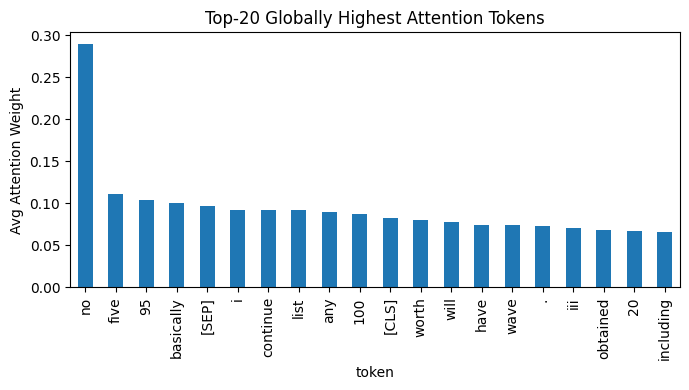

In [114]:
top_k = 20

top_attn = (
    df_attn.groupby("token")["score"]
    .mean()
    .sort_values(ascending=False)
    .head(top_k)
)

plt.figure(figsize=(7,4))
top_attn.plot(kind="bar")
plt.title(f"Top-{top_k} Globally Highest Attention Tokens")
plt.ylabel("Avg Attention Weight")
plt.tight_layout()
plt.show()

Faithfullness

In [115]:
import torch
import numpy as np

DEVICE = torch.device("cpu")
model.to(DEVICE)
model.eval()

def predict_proba_distilbert(texts):
    """
    texts: list[str]
    returns: np.array of shape (N, 2) with class probabilities [p(vague), p(substantive)]
    """
    if isinstance(texts, str):
        texts = [texts]

    all_probs = []
    batch_size = 16

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = tokenizer(
            batch,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=128
        ).to(DEVICE)

        with torch.no_grad():
            logits = model(**enc).logits  # (B,2)
            probs  = torch.softmax(logits, dim=-1).cpu().numpy()

        all_probs.append(probs)

    return np.vstack(all_probs)

In [116]:
def remove_lime_top_k(text, lime_sub_df, k=3):
    """
    text: original sentence (str)
    lime_sub_df: df_lime filtered to this example (idx)
    k: number of highest-|score| LIME features to remove
    """
    # top-k features by absolute importance
    top_feats = (
        lime_sub_df
        .assign(abs_score=lambda d: d["score"].abs())
        .sort_values("abs_score", ascending=False)
        .head(k)["feature"]
        .tolist()
    )

    words = text.split()
    # collect tokens to drop (simple whitespace split of phrases)
    to_drop = set()
    for ph in top_feats:
        for tok in str(ph).split():
            to_drop.add(tok.lower())

    kept = [w for w in words if w.lower() not in to_drop]
    return " ".join(kept)

In [117]:
def lime_faithfulness(texts_eval, preds_eval, df_lime, k=3):
    """
    texts_eval: list[str]
    preds_eval: np.array of predicted class indices for each text
    df_lime: LIME explanations DataFrame
    k: top-k LIME features to remove
    returns: np.array of Δp for each example
    """
    probs_orig = predict_proba_distilbert(texts_eval)  # (N,2)
    deltas = []

    for i, txt in enumerate(texts_eval):
        pred_c = int(preds_eval[i])
        prob_orig = probs_orig[i, pred_c]

        lime_sub = df_lime[df_lime["idx"] == i]
        if lime_sub.empty:
            continue  # skip if no LIME explanation available

        txt_drop = remove_lime_top_k(txt, lime_sub, k=k)
        prob_drop = predict_proba_distilbert([txt_drop])[0, pred_c]

        deltas.append(prob_orig - prob_drop)

    return np.array(deltas)

# run for k=3
delta_lime_k3 = lime_faithfulness(texts_eval, preds_eval, df_lime, k=3)
print("LIME Δp (k=3): mean =", delta_lime_k3.mean(), "std =", delta_lime_k3.std())

LIME Δp (k=3): mean = 0.104430296 std = 0.28138274


In [118]:
def remove_attention_top_k(text, attn_sub_df, k=3):
    """
    text: sentence string
    attn_sub_df: df_attn filtered to this example (idx)
    k: top-k attention tokens to remove
    """
    # highest attention scores → top tokens
    top_tokens = (
        attn_sub_df
        .sort_values("score", ascending=False)
        .head(k)["token"]
        .tolist()
    )

    # normalize: strip '##' and lowercase
    top_norm = {t.replace("##", "").lower() for t in top_tokens}

    words = text.split()
    kept = [w for w in words if w.lower() not in top_norm]
    return " ".join(kept)

In [119]:
def attention_faithfulness(texts_eval, preds_eval, df_attn, k=3):
    probs_orig = predict_proba_distilbert(texts_eval)
    deltas = []

    for i, txt in enumerate(texts_eval):
        pred_c = int(preds_eval[i])
        prob_orig = probs_orig[i, pred_c]

        attn_sub = df_attn[df_attn["idx"] == i]
        if attn_sub.empty:
            continue

        txt_drop = remove_attention_top_k(txt, attn_sub, k=k)
        prob_drop = predict_proba_distilbert([txt_drop])[0, pred_c]

        deltas.append(prob_orig - prob_drop)

    return np.array(deltas)

delta_attn_k3 = attention_faithfulness(texts_eval, preds_eval, df_attn, k=3)
print("Attention Δp (k=3): mean =", delta_attn_k3.mean(), "std =", delta_attn_k3.std())

Attention Δp (k=3): mean = 0.06379251 std = 0.20815802


/var/folders/2y/n4w9x7353854bqjz2kyz8y300000gn/T/ipykernel_20393/3815548737.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([delta_lime_k3, delta_attn_k3], labels=["LIME", "Attention"])


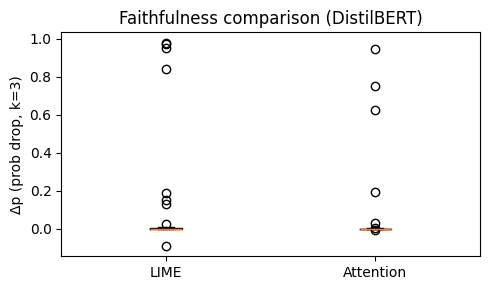

In [120]:
plt.figure(figsize=(5,3))
plt.boxplot([delta_lime_k3, delta_attn_k3], labels=["LIME", "Attention"])
plt.ylabel("Δp (prob drop, k=3)")
plt.title("Faithfulness comparison (DistilBERT)")
plt.tight_layout()
plt.show()

Got Spearman ρ for 40 examples.
Mean ρ (LIME vs Attention): 0.18017224626969996
Std  ρ: 0.4234531826964683


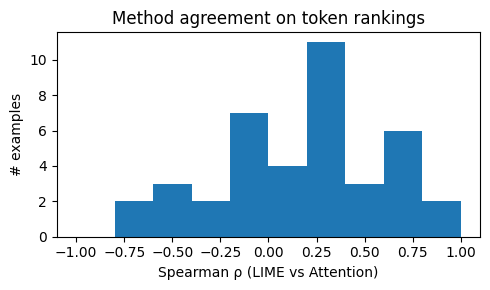

In [121]:
from scipy.stats import spearmanr

def normalize_token(t):
    return t.replace("##", "").lower()

def lime_token_scores_for_idx(i):
    """
    Aggregate LIME phrase scores into per-token scores for example idx=i.
    Returns dict: token -> score
    """
    sub = df_lime[df_lime["idx"] == i]
    tok_scores = {}

    for _, row in sub.iterrows():
        phrase = str(row["feature"]).lower()
        w = float(row["score"])
        for tok in phrase.split():
            tok_scores[tok] = tok_scores.get(tok, 0.0) + w

    return tok_scores

rho_values = []

for i in range(len(texts_eval)):
    # token-level LIME scores
    lime_scores = lime_token_scores_for_idx(i)
    if not lime_scores:
        continue

    # token-level attention scores
    attn_sub = df_attn[df_attn["idx"] == i]
    attn_tokens = [normalize_token(t) for t in attn_sub["token"].tolist()]
    attn_vals   = np.array(attn_sub["score"].tolist())

    xs, ys = [], []
    for tok, sc in zip(attn_tokens, attn_vals):
        if tok in lime_scores:
            xs.append(lime_scores[tok])  # LIME
            ys.append(sc)                # Attention

    if len(xs) >= 3:
        rho, _ = spearmanr(xs, ys)
        if not np.isnan(rho):
            rho_values.append(rho)

print(f"Got Spearman ρ for {len(rho_values)} examples.")
print("Mean ρ (LIME vs Attention):", np.mean(rho_values))
print("Std  ρ:", np.std(rho_values))

plt.figure(figsize=(5,3))
plt.hist(rho_values, bins=10, range=(-1,1))
plt.xlabel("Spearman ρ (LIME vs Attention)")
plt.ylabel("# examples")
plt.title("Method agreement on token rankings")
plt.tight_layout()
plt.show()

In [122]:
def show_example_explanations(i, k=8):
    txt = texts_eval[i]
    true_c = labels_eval[i]
    pred_c = preds_eval[i]

    print("="*80)
    print(f"Example {i} | true={true_c}, pred={pred_c}")
    print("Text:", txt)
    print("-"*80)

    # LIME
    print("Top LIME features:")
    sub_lime = df_lime[df_lime["idx"] == i].copy()
    if not sub_lime.empty:
        sub_lime["abs_score"] = sub_lime["score"].abs()
        for _, row in sub_lime.sort_values("abs_score", ascending=False).head(k).iterrows():
            print(f"{row['feature']:>25s}  {row['score']: .4f}")
    else:
        print("  (no LIME explanation)")

    print("\nTop Attention tokens:")
    sub_attn = df_attn[df_attn["idx"] == i].copy()
    if not sub_attn.empty:
        for _, row in sub_attn.sort_values("score", ascending=False).head(k).iterrows():
            print(f"{row['token']:>25s}  {row['score']: .4f}")
    else:
        print("  (no attention scores)")

# Try it for a substantive example and a vague example
show_example_explanations(0)
show_example_explanations(1)

Example 0 | true=1, pred=1
Text: its environmental management institutions and corporate environmental management systems are sound, and environmental archive management is relatively complete. no environmental disputes or penalties for violations have occurred.
--------------------------------------------------------------------------------
Top LIME features:
                       no   0.7475
                 occurred   0.1140
            environmental   0.1133
               violations   0.0862
                     have   0.0794
                penalties   0.0650
                      and   0.0619
                       or  -0.0528

Top Attention tokens:
                       no   0.2888
                        .   0.1879
                     have   0.1261
                        .   0.0704
                    [CLS]   0.0702
                       or   0.0601
                 occurred   0.0562
                    [SEP]   0.0487
Example 1 | true=1, pred=1
Text: integrate intellectua

In [123]:
import torch
import numpy as np

def predict_with_probs(text):
    """
    text: a single sentence (string)
    returns: (p_pred_class, probs_array)
      - p_pred_class = probability of predicted label
      - probs_array = array([p_vague, p_substantive])
    """
    model.eval()
    inputs = tokenizer(
        text,
        truncation=True,
        padding="max_length",
        max_length=128,
        return_tensors="pt"
    )

    with torch.no_grad():
        outputs = model(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"]
        )
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1).cpu().numpy()[0]

    pred_label = np.argmax(probs)
    p_pred = probs[pred_label]

    return p_pred, probs

In [124]:
def attention_importance(texts, model, tokenizer, max_len=128, device=DEVICE):
    """
    texts: list[str] – raw sentences
    returns:
      tokens_list:  list[list[str]]   – wordpiece tokens per example
      scores_list:  list[np.ndarray]  – attention-based importance per token
    """
    model.eval()
    
    enc = tokenizer(
        texts,
        truncation=True,
        padding="max_length",
        max_length=max_len,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        outputs = model(
            input_ids=enc["input_ids"],
            attention_mask=enc["attention_mask"],
            output_attentions=True
        )

    # last layer attentions: (batch, n_heads, L, L)
    last_attn = outputs.attentions[-1]          # (B, H, L, L)
    # average over heads
    attn_mean = last_attn.mean(dim=1)           # (B, L, L)
    # CLS is position 0 → take attention from CLS to every token
    cls_to_tok = attn_mean[:, 0, :]             # (B, L)

    tokens_list = []
    scores_list = []

    for i in range(cls_to_tok.size(0)):
        ids = enc["input_ids"][i].cpu().tolist()
        toks = tokenizer.convert_ids_to_tokens(ids)

        scores = cls_to_tok[i].cpu().numpy()
        # mask out padding
        mask = enc["attention_mask"][i].cpu().numpy().astype(bool)
        toks = [t for t, m in zip(toks, mask) if m]
        scores = scores[mask]

        # normalize per example (sum to 1)
        s_sum = scores.sum()
        if s_sum > 0:
            scores = scores / s_sum

        tokens_list.append(toks)
        scores_list.append(scores)

    return tokens_list, scores_list

In [125]:
import pandas as pd
import numpy as np
from scipy.special import softmax

# ---------- 1. Re-run deletion test once in a structured way ----------

K = 3  # top-k tokens removed

rows = []

for i, txt in enumerate(texts_eval):          # texts_eval = list of sentences
    true_lab = int(labels_eval[i])            # 0/1 labels for these examples

    # original prediction
    p_orig, probs_orig = predict_with_probs(txt)   # you already have this helper
    pred_lab = int(np.argmax(probs_orig))

    # skip misclassified if you want “on-correct-only”
    if pred_lab != true_lab:
        continue

    # ----- LIME importance for this example -----
    exp_l = explainer_lime.explain_instance(
        txt,
        predict_proba_distilbert,
        num_features=10,
        labels=[pred_lab],
        num_samples=500,
    )
    lime_feats = exp_l.as_list(label=pred_lab)  # list[(token, weight)]

    # helper to delete top-k tokens by LIME weight
    def delete_topk_lime(text, feats, k=K):
        toks = text.split()
        # sort features by importance magnitude
        sorted_feats = sorted(feats, key=lambda x: -abs(x[1]))[:k]
        removed = set([f[0].strip() for f in sorted_feats])
        new_toks = [t for t in toks if t not in removed]
        return " ".join(new_toks)

    txt_lime_del = delete_topk_lime(txt, lime_feats, k=K)
    p_lime_del, _ = predict_with_probs(txt_lime_del)

    rows.append({
        "method": "LIME",
        "delta_p": float(p_orig - p_lime_del),
        "true_label": true_lab,
    })

    # ----- Attention importance for this example -----
    toks_att, scores_att = attention_importance([txt], model, tokenizer)
    toks_att = toks_att[0]
    scores_att = scores_att[0]

    # indices of top-k tokens by attention
    topk_idx = np.argsort(-scores_att)[:K]
    top_tokens = set([toks_att[j] for j in topk_idx])

    # crude delete: drop tokens whose lowercased form is in top_tokens
    toks = txt.split()
    new_toks = [t for t in toks if t.lower() not in top_tokens]
    txt_att_del = " ".join(new_toks)

    p_att_del, _ = predict_with_probs(txt_att_del)

    rows.append({
        "method": "Attention",
        "delta_p": float(p_orig - p_att_del),
        "true_label": true_lab,
    })

df_faith = pd.DataFrame(rows)
df_faith.head()

,method,delta_p,true_label
0,LIME,-0.030950,1
1,Attention,-0.025273,1
2,LIME,0.129525,1
3,Attention,-0.000299,1
4,LIME,0.000752,0


In [126]:
df_faith

,method,delta_p,true_label
0,LIME,-0.030950,1
1,Attention,-0.025273,1
2,LIME,0.129525,1
3,Attention,-0.000299,1
4,LIME,0.000752,0
...,...,...,...
75,Attention,0.000020,1
76,LIME,0.000365,0
77,Attention,0.000000,0
78,LIME,0.000117,0


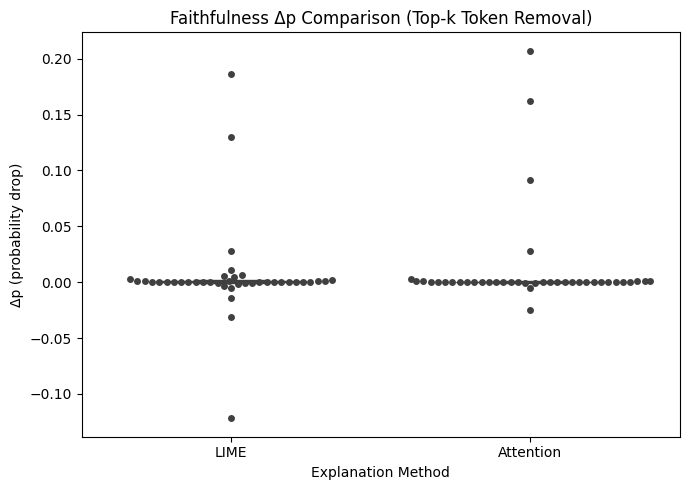

In [127]:
plt.figure(figsize=(7,5))
sns.boxplot(data=df_faith, x="method", y="delta_p", width=0.5, showfliers=False)
sns.swarmplot(data=df_faith, x="method", y="delta_p", color=".25")

plt.title("Faithfulness Δp Comparison (Top-k Token Removal)")
plt.ylabel("Δp (probability drop)")
plt.xlabel("Explanation Method")
plt.tight_layout()
plt.show()

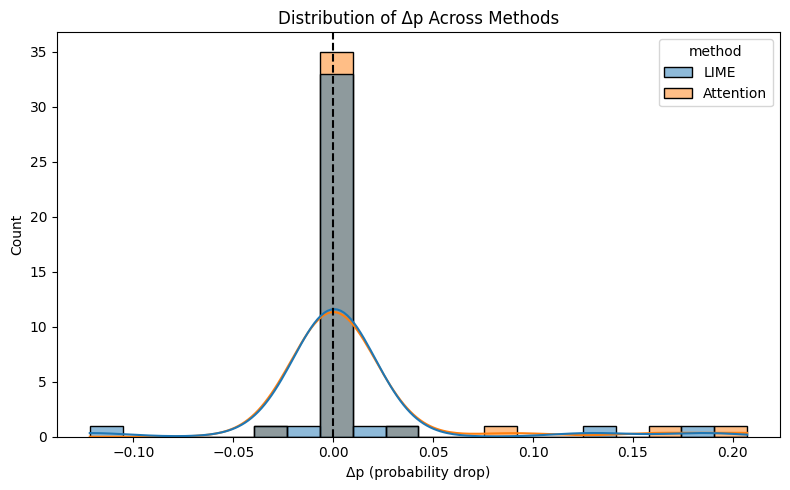

In [128]:
plt.figure(figsize=(8,5))
sns.histplot(data=df_faith, x="delta_p", hue="method", kde=True, bins=20)

plt.axvline(0, color='black', linestyle='--')
plt.title("Distribution of Δp Across Methods")
plt.xlabel("Δp (probability drop)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

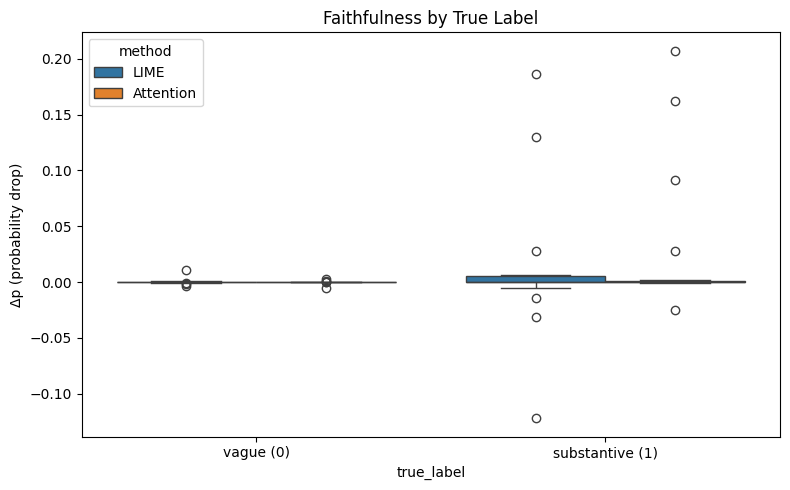

In [129]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df_faith, x="true_label", y="delta_p", hue="method")
plt.xticks([0,1], ["vague (0)", "substantive (1)"])
plt.ylabel("Δp (probability drop)")
plt.title("Faithfulness by True Label")
plt.tight_layout()
plt.show()

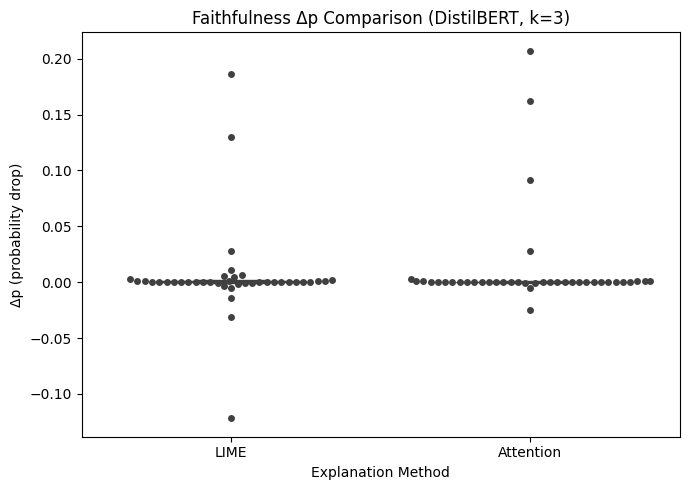

In [130]:
plt.figure(figsize=(7,5))
sns.boxplot(data=df_faith, x="method", y="delta_p", width=0.5, showfliers=False)
sns.swarmplot(data=df_faith, x="method", y="delta_p", color=".25")

plt.title("Faithfulness Δp Comparison (DistilBERT, k=3)")
plt.ylabel("Δp (probability drop)")
plt.xlabel("Explanation Method")
plt.tight_layout()
plt.show()